In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import sem
from tensorflow.examples.tutorials.mnist import input_data
import sys
from simple_rl.tasks.navigation.NavigationWorldMDP import *

sys.path.append("../")
sys.path.append("../Datasets/")
from utils.ImageSampler import ImageSampler

In [2]:
from xview.xview_wrapper import MicroXView
use_grayscale = True
input_shape = [32, 32, 1] if use_grayscale else [32, 32, 3]

img_data = MicroXView(one_hot=False, shuffle=True, use_grayscale=use_grayscale, 
                     dataset_dir="../Datasets/xview/xView_data/micro-xview-v1/")
img_sampler = ImageSampler(img_data)
sample_train_img_seq = lambda c_lst: np.reshape(img_sampler.sample_image_train(c_lst), [-1] + input_shape)
sample_test_img_seq = lambda c_lst: np.reshape(img_sampler.sample_image_test(c_lst), [-1] + input_shape)

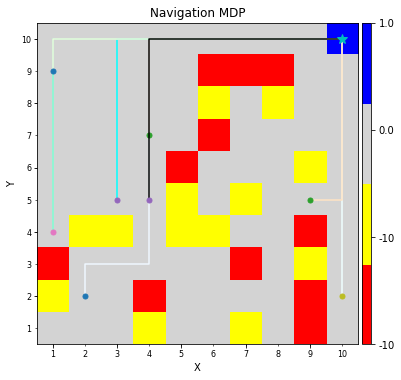

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c50482b38>)

In [5]:
np.random.seed(0)
nvmdp = NavigationWorldMDP(width=10, height=10, 
                      nav_cell_types=['red', "yellow", 'lightgray'],
                      nav_cell_rewards=[-10, -10, 0.],
                      nav_cell_p_or_locs=[0.1, 0.1, 0.8],
                      goal_cell_locs=[[(10, 10)]],
                      goal_cell_rewards=[1.],
                      goal_cell_types=["blue"],
                      slip_prob=0.00, step_cost=0.0, gamma=.99)
cell_type_to_class_map = {"red": "Truck", "yellow": "Excavator", 
                      "blue": "Storage Tank", "lightgray": "None"}
state_id_to_class_map = {nvmdp.cell_type_to_id[k]: v for k,v in cell_type_to_class_map.items()}
state_id_to_class_id_map = {nvmdp.cell_type_to_id[k]: img_data.class_label_to_id[v] \
                            for k,v in cell_type_to_class_map.items()}

traj_states_list, traj_action_list = nvmdp.sample_trajectories(n_traj=8, horizon=100, 
                                                               init_states=[NavigationWorldState(2,2)],
                                                               init_cell_types=["lightgray"], init_unique=True,
                                                               rand_init_to_match_n_traj=True)
nvmdp.visualize_grid(trajectories=traj_states_list, show_colorbar=True, show_rewards_colorbar=True, goal_marker="*c")

In [10]:
def sample_train_img_mat(class_id_mat):
    
    img_grid = []
    for class_ids_lst in class_id_mat:
        img_grid.extend(sample_train_img_seq(class_ids_lst))
        
    return np.asarray(img_grid)

def image_stack_to_grid(img_stack, nrow, padding, img_dim):
    """
    Creates image grid of size nrow x (n/nrows) from image stack.

    :param img_stack (numpy array): a set of images in (N x H x W x C) format
    :param nrow: number of rows in grid
    :returns: image sprite with set of images laid out in a grid
    """
    H, W, C = img_dim
    import torch
    from torchvision import utils
    return utils.make_grid(
        torch.tensor(img_stack).permute(0, 3, 1, 2), nrow=nrow, padding=padding).permute(1, 2, 0)

In [11]:
img_stack = sample_train_img_mat([[state_id_to_class_id_map[col] for col in row] for row in nvmdp.map_state_cell_id])

In [15]:
t = image_stack_to_grid(img_stack, nvmdp.height, 0, (32, 32, 1))

In [77]:
color_to_class_lbl_str = "".join([ "{:>20}: {:<20}\n".format(k.lower(), v.lower()) for k,v in cell_type_to_class_map.items()])
print(color_to_class_lbl_str)

                 red: truck               
              yellow: excavator           
                blue: storage tank        
           lightgray: none                



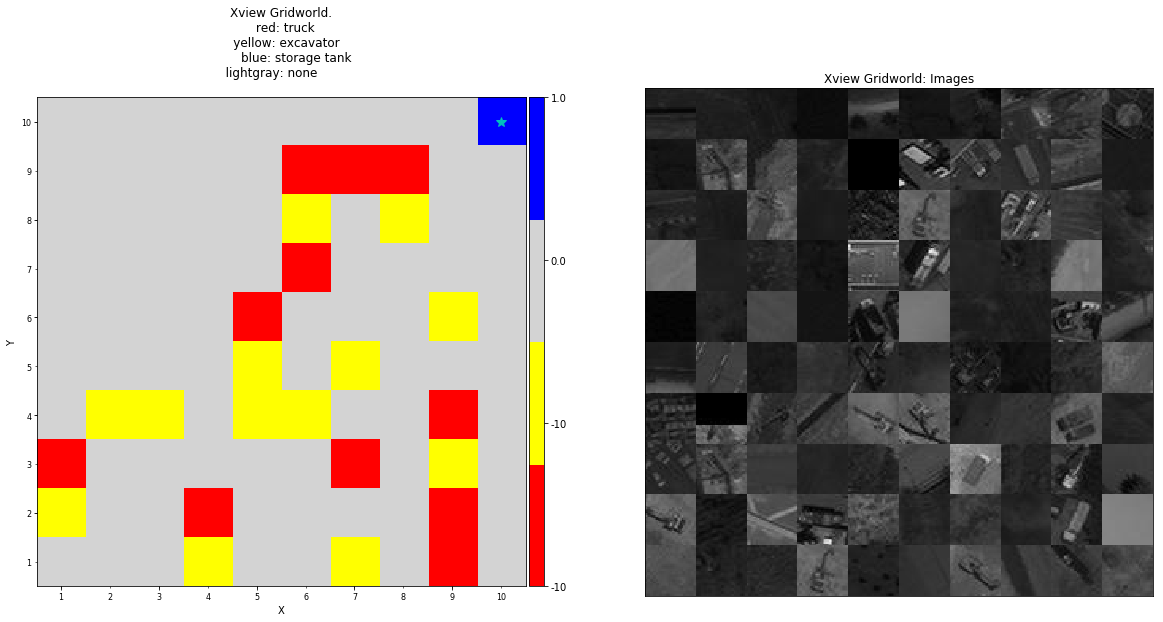

In [89]:
fig = plt.figure(figsize=(20,12))
fig, ax = nvmdp.visualize_grid(trajectories=None, show_colorbar=True, 
                               show_rewards_colorbar=True, goal_marker="*c", fig=fig, subplot_str="121",
                              title="Xview Gridworld.\n{}".format(color_to_class_lbl_str))
ax = fig.add_subplot(122)
ax.imshow(t.numpy(), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
_ = ax.set_title("Xview Gridworld: Images")